In [3]:
import os
from os.path import join
from scipy.io import loadmat
from scipy import signal
import glob
import pickle
import numpy as np
from antropy import lziv_complexity
from neurokit2.complexity import complexity_lempelziv
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from mne import viz, stats
from matplotlib import pyplot as plt

In [4]:
data_dir = "../transformer/data/200/"
result_dir = "../results/lziv"

stages = ["AWSL", "NREM", "REM"]
conditions = ["CAF", "PLAC"]

In [5]:
def get_paths(root, subject="*", stage="*", condition="*"):
    return glob.glob(join(root, f"{subject}n*_{stage}_*_{condition}.npy"))

In [ ]:
n_jobs = -1

def complexity(epoch, use_psd=False):
    if use_psd:
        # TODO: maybe use something other than median split to binarize the PSD
        epoch = signal.welch(epoch, fs=256, nperseg=len(epoch) // 6, noverlap=0, window='hamming')[1]
    #return lziv_complexity((epoch > np.median(epoch)).astype(int), normalize=True)
    return complexity_lempelziv(epoch, normalize=True)[0]

result = {}
for stage in stages:
    result[stage] = {}
    for condition in conditions:
        print(f"processing {stage} {condition}:")
        # load data
        paths = get_paths(data_dir, stage=stage, condition=condition)
        
        data = {}
        for path in tqdm(paths, desc="loading data"):
            subject = path.split(os.sep)[-1].split("_")[0].split("n")[0]
            if subject in data:
                data[subject] = np.concatenate([data[subject], np.load(path)])
            else:
                data[subject] = np.load(path)
        
        result[stage][condition] = []
        for subject in tqdm(data.keys(), desc="estimating complexity"):
            dat = data[subject].transpose((0, 2, 1)).reshape(-1, 5120)
            res = Parallel(n_jobs=n_jobs)(delayed(complexity)(epoch) for epoch in dat)
            result[stage][condition].append(np.array(res).reshape(-1, 20).mean(axis=0))
        result[stage][condition] = np.stack(result[stage][condition])
        
    result[stage] = stats.permutation_t_test(result[stage]["CAF"] - result[stage]["PLAC"],
                                             n_permutations=10, tail=0, n_jobs=n_jobs)

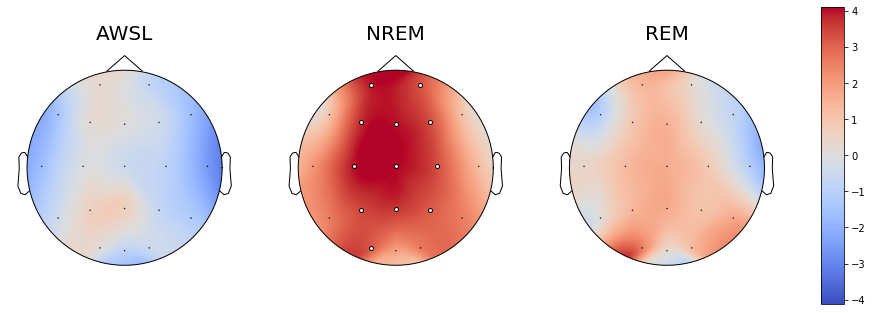

In [14]:
def plot_lziv(pkl_file):
    with open(pkl_file, "rb") as f:
        result = pickle.load(f)[1]
        
    # load EEG sensor positions to be used in the topomaps
    sensor_pos = loadmat(join("../data", 'Coo_caf'))['Cor'].T
    sensor_pos = np.array([sensor_pos[1], sensor_pos[0]]).T
    
    absmax = max(abs(min(val[0].min() for val in result.values())), abs(max(val[0].max() for val in result.values())))
    vmin = -absmax
    vmax = absmax

    fig, axes = plt.subplots(ncols=4, figsize=(15, 5), gridspec_kw=dict(width_ratios=[1] * len(stages) + [0.1]))
    for stage, ax in zip(stages, axes[:-1]):
        curr_t = result[stage][0]
        curr_p = result[stage][1]
        mask = curr_p < 0.05

        ax.set_title(stage, fontsize=20)
        viz.plot_topomap(curr_t, sensor_pos, mask=mask, vmin=vmin, vmax=vmax, contours=False, axes=ax, show=False, cmap="coolwarm")

    from matplotlib import colors

    norm = colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
    sm.set_array([])
    plt.colorbar(sm, cax=axes[-1])
    plt.show()
    
plot_lziv(join(result_dir, "lziv.pkl"))

In [15]:
with open(join(result_dir, "lziv.pkl"), "rb") as f:
    result, _ = pickle.load(f)